## Installation

In [ ]:
!python -m pip install keras_cv datasets transformers tensorboard tensorflow ipywidgets opencv-python tensorflow-datasets scikit-learn
!git-lfs --version

Login to huggingface if first time

In [ ]:
from huggingface_hub import notebook_login

notebook_login()


Show that the GPU is being used

In [1]:
from tensorflow.config.experimental import list_physical_devices
print(list_physical_devices('GPU'))

model_id = "google/vit-base-patch16-224-in21k"

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Now create the database, also this is the time to define data augmentation

In [2]:
from transformers import ViTImageProcessor
from datasets import load_dataset
from tensorflow import device
from tensorflow import keras
from tensorflow.keras import layers
from keras_cv.layers import RandAugment
import tensorflow as tf

# Define the model ID and other parameters
num_layers = 2
magnitude = 0.15

# Load the ViTImageProcessor
image_processor = ViTImageProcessor.from_pretrained(model_id)

# Create RandAugment transformation
rand_augment = RandAugment(
    value_range=[-1,1],
    augmentations_per_image=num_layers,
    magnitude=magnitude,
)


def transform(batch):
    inputs = image_processor([x for x in batch["image"]], return_tensors="tf")
    inputs["labels"] = batch["label"]
    return inputs

def augment(batch):
    inputs = image_processor([x for x in batch["image"]], return_tensors="tf")
    transposed = tf.transpose(inputs["pixel_values"], perm=[0,3,2,1])
    with device('/cpu:0'):
        augmented = rand_augment(transposed)
    inputs["pixel_values"] = tf.transpose(augmented, perm=[0,3,2,1])
    inputs["labels"] = batch["label"]
    return inputs

dataset = load_dataset("streetview_images_cropped", data_dir="./")

eval_size=.15
test_size=.05

dataset = dataset["train"].shuffle().train_test_split(test_size=test_size)
dataset_final_test = dataset['test'].with_transform(transform)

dataset = dataset["train"].train_test_split(test_size=eval_size)
dataset['train'] = dataset['train'].with_transform(augment)
dataset['test'] = dataset['test'].with_transform(transform)
processed_dataset = dataset

Using TensorFlow backend


Resolving data files:   0%|          | 0/42570 [00:00<?, ?it/s]

Specify hyperparameters

In [3]:
from huggingface_hub import HfFolder
import tensorflow as tf

class_labels = processed_dataset['train'].features["label"].names
num_images_train = processed_dataset['train'].num_rows
id2label = {str(i): label for i, label in enumerate(class_labels)}
label2id = {v: k for k, v in id2label.items()}

num_train_epochs = 20
train_batch_size = 16
eval_batch_size = 16
learning_rate = 6e-5
adam_beta1 = 0.85 # 0.9
adam_beta2 = 0.95 # 0.999
weight_decay_rate=0.01
num_warmup_steps=20
output_dir=model_id.split("/")[1]
hub_token = HfFolder.get_token()
hub_model_id = f'dl-au-tamas-jedrek/{model_id.split("/")[1]}-street-view'


In [4]:
import json

with open("data/distances.json", "r") as infile:
    distances = json.load(infile)

#make matrix with label2id
import numpy as np
mat_distances = np.zeros((len(label2id), len(label2id)))
for key in distances.keys():
    for key2 in distances[key].keys():
        mat_distances[int(label2id[key])][int(label2id[key2])] = distances[key][key2]
#normalize
factor = np.max(mat_distances)
mat_distances = mat_distances / factor
mat_distances

array([[0.        , 0.52141711, 0.51932925, ..., 0.35854885, 0.38460101,
        0.15598868],
       [0.52141711, 0.        , 0.00872377, ..., 0.16537892, 0.58535648,
        0.55115671],
       [0.51932925, 0.00872377, 0.        , ..., 0.16222863, 0.58921171,
        0.55154728],
       ...,
       [0.35854885, 0.16537892, 0.16222863, ..., 0.        , 0.49144118,
        0.40681518],
       [0.38460101, 0.58535648, 0.58921171, ..., 0.49144118, 0.        ,
        0.23601351],
       [0.15598868, 0.55115671, 0.55154728, ..., 0.40681518, 0.23601351,
        0.        ]])

Get model, specify loss and metrics

In [5]:
import tensorflow as tf
from transformers import TFViTModel

base_model = TFViTModel.from_pretrained(model_id, output_attentions = True)
pixel_values = tf.keras.layers.Input(shape=(3,224,224), name='pixel_values', dtype='float32')
vit = base_model.vit(pixel_values)[0]
classifier = tf.keras.layers.Dense(len(class_labels), activation='softmax', name='outputs')(vit[:, 0, :])
model = tf.keras.Model(inputs=pixel_values, outputs=classifier)

2023-12-03 15:41:23.099334: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-12-03 15:41:23.099416: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-03 15:41:23.099427: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-03 15:41:23.099550: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-03 15:41:23.099845: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your

In [6]:
import tensorflow as tf

tensor_distances = tf.convert_to_tensor(mat_distances, dtype=tf.float32)
def calculate_all_distance(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    indexed_distances = tf.gather(tensor_distances, y_true)
    multiplied = tf.multiply(y_pred, indexed_distances)
    dist = tf.reduce_sum(multiplied, axis=1)
    return dist
def calculate_best_distance(y_true, y_pred):
    y_pred_label = tf.argmax(y_pred, axis=1)
    y_true = tf.reshape(y_true, [-1])
    indices = tf.stack((y_true, y_pred_label), axis=1)
    dist = tf.gather_nd(tensor_distances, indices)
    return dist

def customLoss(y_true, y_pred):
    dist = calculate_all_distance(y_true, y_pred)
    return ((dist+1) ** 2) + tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)

#loss=tf.keras.losses.SparseCategoricalCrossentropy()
loss = customLoss

def best_distance(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int64)
    dist = calculate_best_distance(y_true, y_pred)
    return tf.reduce_mean(dist) * factor

def all_distance(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int64)
    dist = calculate_all_distance(y_true, y_pred)
    return tf.reduce_mean(dist) * factor


In [7]:
from transformers import create_optimizer

# create optimizer wight weigh decay
num_train_steps = num_images_train * num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    adam_beta1=adam_beta1,
    adam_beta2=adam_beta2,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=num_warmup_steps,

)
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32)
    return lr
lr_metric = get_lr_metric(optimizer)

# define metrics 
metrics=[
    tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
    best_distance,
    all_distance,
    tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
    lr_metric,
]

In [8]:
model.layers[1].trainable = True
model.summary()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pixel_values (InputLayer)   [(None, 3, 224, 224)]     0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPo   86389248  
                             oling(last_hidden_state             
                             =(None, 197, 768),                  
                              pooler_output=(None, 7             
                             68),                                
                              hidden_states=None, at             
                             tentions=((None, 12, No             
                             ne, None),                          
                              (None, 12, None, None)             
                             , (None, 12, None, None             
                             ),                              

Transform dataset for training

In [9]:
#tf_train_dataset = model.prepare_tf_dataset(processed_dataset['train'], batch_size=train_batch_size, shuffle=True)
#tf_eval_dataset = model.prepare_tf_dataset(processed_dataset['test'], batch_size=eval_batch_size, shuffle=True)
#tf_test_dataset = model.prepare_tf_dataset(dataset_final_test, batch_size=eval_batch_size, shuffle=True)

from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors="tf")

tf_train_dataset = processed_dataset["train"].to_tf_dataset(
   columns=['pixel_values'],
   label_cols=["labels"],
   shuffle=True,
   batch_size=train_batch_size,
   collate_fn=data_collator)
tf_eval_dataset = processed_dataset["test"].to_tf_dataset(
    columns=['pixel_values'],
    label_cols=["labels"],
    shuffle=True,
    batch_size=eval_batch_size,
    collate_fn=data_collator)
tf_test_dataset = dataset_final_test.to_tf_dataset(
    columns=['pixel_values'],
    label_cols=["labels"],
    shuffle=True,
    batch_size=eval_batch_size,
    collate_fn=data_collator)

/opt/homebrew/anaconda3/envs/tf/lib/python3.9/site-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


Run to display train images

In [ ]:
#import matplotlib.pyplot as plt

#sample_images, sample_labels = next(iter(tf_train_dataset))
#plt.figure(figsize=(10, 10))
#for i, image in enumerate(sample_images[:9]):
#    ax = plt.subplot(3, 3, i + 1)
#    transposed = tf.transpose(image)
#    plt.imshow(transposed.numpy())
#    plt.axis("off")

Push metrics to hub after every epoch

In [10]:
import os
from transformers.keras_callbacks import PushToHubCallback
from tensorflow.keras.callbacks import TensorBoard as TensorboardCallback, EarlyStopping, Callback
from huggingface_hub import push_to_hub_keras

log_dir = os.path.join(output_dir, "logs")
class CustomPushToHubCallback(Callback):
    def on_train_end(self, epoch, logs=None):
        push_to_hub_keras(model, hub_model_id, log_dir=log_dir)

callbacks = []
callbacks.append(TensorboardCallback(log_dir=log_dir))
callbacks.append(CustomPushToHubCallback())
#callbacks.append(EarlyStopping(monitor="val_accuracy",patience=1))
#callbacks.append(PushToHubCallback(
#    output_dir,
#    hub_model_id=hub_model_id,
#    hub_token=hub_token,
#))

Train model

In [11]:
from transformers import logging as transformers_logging
transformers_logging.set_verbosity_info()
train_results = model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset,
    callbacks=callbacks,
    epochs=num_train_epochs,
    verbose=1
)

Epoch 1/20


2023-12-03 15:41:34.727867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2149/2149 [==============================] - 3084s 1s/step - loss: 6.0301 - accuracy: 0.0691 - best_distance: 101.9496 - all_distance: 122.6740 - top-3-accuracy: 0.1449 - lr: 5.9643e-05 - val_loss: 5.5347 - val_accuracy: 0.1389 - val_best_distance: 88.5544 - val_all_distance: 112.6028 - val_top-3-accuracy: 0.2550 - val_lr: 5.9814e-05
Epoch 2/20
2149/2149 [==============================] - 3063s 1s/step - loss: 5.3129 - accuracy: 0.1652 - best_distance: 85.1026 - all_distance: 108.2829 - top-3-accuracy: 0.3062 - lr: 5.9720e-05 - val_loss: 5.0845 - val_accuracy: 0.1971 - val_best_distance: 79.6709 - val_all_distance: 101.0355 - val_top-3-accuracy: 0.3448 - val_lr: 5.9627e-05
Epoch 3/20
2149/2149 [==============================] - 3068s 1s/step - loss: 4.7617 - accuracy: 0.2443 - best_distance: 73.7989 - all_distance: 96.6757 - top-3-accuracy: 0.4210 - lr: 5.9533e-05 - val_loss: 4.7262 - val_accuracy: 0.2497 - val_best_distance: 72.4390 - val_all_distance: 93.1316 - val_top-3-accuracy: 0.

INFO:tensorflow:Assets written to: /var/folders/30/vk_cflhx60b0_vp0jphqhgnrwxfqjv/T/tmpzargb1fi/dl-au-tamas-jedrek/vit-base-patch16-224-in21k-street-view/assets


events.out.tfevents.1701350318.d55519.96165.0.v2:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

events.out.tfevents.1701349062.d55519.77260.0.v2:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/177k [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

Upload 23 LFS files:   0%|          | 0/23 [00:00<?, ?it/s]

events.out.tfevents.1701349118.d55519.77260.1.v2:   0%|          | 0.00/2.51M [00:00<?, ?B/s]

events.out.tfevents.1701350566.d55519.96165.1.v2:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

events.out.tfevents.1701350609.d55519.96599.0.v2:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

events.out.tfevents.1701350741.d55519.96599.1.v2:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

events.out.tfevents.1701351156.d55519.96599.2.v2:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

events.out.tfevents.1701351508.d55519.97006.0.v2:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

events.out.tfevents.1701512891.d55519.46481.0.v2:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

events.out.tfevents.1701530188.d55519.63378.0.v2:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

events.out.tfevents.1701547532.d55519.3262.0.v2:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

events.out.tfevents.1701601166.d55519.24117.0.v2:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

events.out.tfevents.1701614487.d55519.37303.0.v2:   0%|          | 0.00/2.49M [00:00<?, ?B/s]

events.out.tfevents.1701354557.d55519.97006.1.v2:   0%|          | 0.00/4.04k [00:00<?, ?B/s]

events.out.tfevents.1701515927.d55519.46481.1.v2:   0%|          | 0.00/4.04k [00:00<?, ?B/s]

events.out.tfevents.1701533157.d55519.63378.1.v2:   0%|          | 0.00/4.04k [00:00<?, ?B/s]

events.out.tfevents.1701550501.d55519.3262.1.v2:   0%|          | 0.00/4.04k [00:00<?, ?B/s]

events.out.tfevents.1701604096.d55519.24117.1.v2:   0%|          | 0.00/4.04k [00:00<?, ?B/s]

events.out.tfevents.1701617384.d55519.37303.1.v2:   0%|          | 0.00/20.0k [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/4.51M [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/346M [00:00<?, ?B/s]

## Attention heatmap

### Create partial model to display

In [12]:
layer_index = 1  # Attention layer index 
attention_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(index=layer_index).output)

### Prepare an image

In [13]:
one_image = tf_test_dataset.take(1)

# Now, you can iterate through the one_image dataset to get the individual image and label
for image_batch, label_batch in one_image:
    # Assuming image_batch has shape (32, 3, 224, 224) and label_batch has shape (32,)
    # You can select one image from the batch, for example, the first image:
    single_image = image_batch
    single_label = label_batch[0]
    print(f"Loaded {single_label}")


preprocessed_image = tf.transpose(single_image[0])
# De-normalize the image for visual clarity.
in1k_mean = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])
in1k_std = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])
preprocessed_img_orig = (preprocessed_image * in1k_std) + in1k_mean
preprocessed_img_orig = preprocessed_img_orig / 255.0
preprocessed_img_orig = tf.clip_by_value(preprocessed_img_orig, 0.0, 1.0)
preprocessed_img_orig = tf.image.flip_left_right(preprocessed_img_orig)
preprocessed_img_orig = tf.image.rot90(preprocessed_img_orig).numpy()

Loaded 83


### Get attention scores

In [14]:
result = attention_model(single_image)
attention_score = result.attentions

### Display attention heatmap

(-0.5, 223.5, 223.5, -0.5)

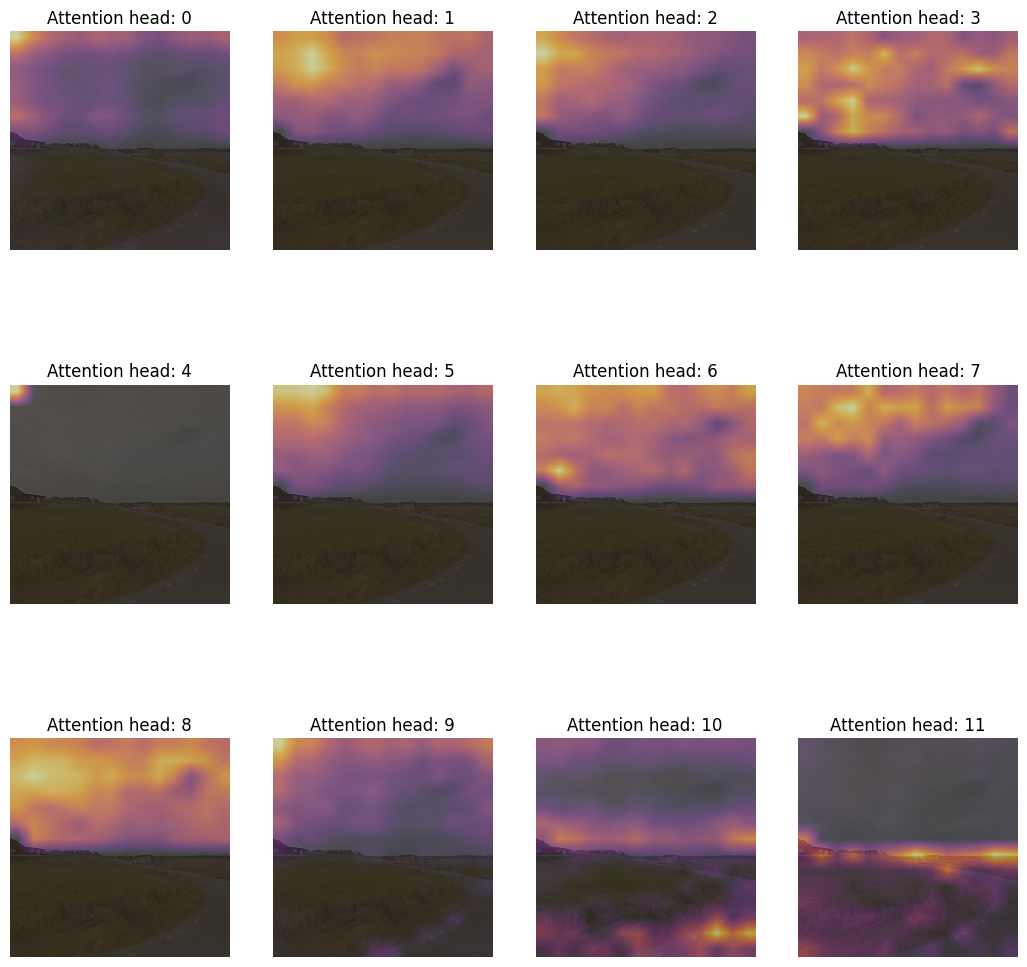

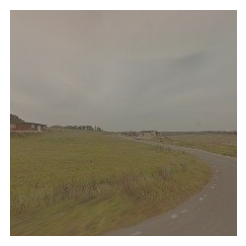

In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def attention_heatmap(attention_scores, image, model_type="dino"):
    num_tokens = 2 if "distilled" in model_type else 1
    batch_size = 32
    num_heads = 12
    patch_size = 16

    # Process the attention maps for overlay.
    w_featmap = 224 // patch_size
    h_featmap = 224 // patch_size

    # Taking the representations from CLS token.
    attentions = attention_scores[0, :, 1, num_tokens:].numpy().reshape(num_heads, -1)

    # Reshape the attention scores to resemble mini patches.
    attentions = attentions.reshape(num_heads, w_featmap, h_featmap)
    attentions = attentions.transpose((1, 2, 0))

    # Resize the attention patches to 224x224 (224: 14x16).
    attentions = tf.image.resize(
        attentions, size=(224,224)
    ) 
    return attentions

# Generate the attention heatmaps.
attentions = attention_heatmap(attention_score[0], preprocessed_img_orig)

# Plot the maps.
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13, 13))
img_count = 0

for i in range(3):
    for j in range(4):
        if img_count < len(attentions):
            axes[i, j].imshow(preprocessed_img_orig)
            axes[i, j].imshow(attentions[..., img_count], cmap="inferno", alpha=0.5)
            axes[i, j].title.set_text(f"Attention head: {img_count}")
            axes[i, j].axis("off")
            img_count += 1

plt.figure(figsize=(10, 10))
ax = plt.subplot(3, 3, 1)
plt.imshow(preprocessed_img_orig)
plt.axis("off")

## Confusion Matrix

1/1 [==============================] - 1s 1s/step
[ 70 125  29  86  78 115  28  98 102 115  86  65 115   9  64  78]
[ 68 123  27  74  78 120  28  98  38  53 120  65  53  13  73 100]
1/1 [==============================] - 1s 1s/step
[115   1  77   2  38 113  11  77  40 123 111  73  39  64  23  53]
[ 78  13  77   2  56  88  11 125 117  85 111   9  65  64  46  87]
1/1 [==============================] - 1s 879ms/step
[  7   6  23 122  83  69 108  20 108  50  88 115  82 114 126  99]
[100   6 117 125  99  69 108  21  44 101  88  46  82 116   1  51]
1/1 [==============================] - 1s 746ms/step
[ 25  70   3  46  20  18  45  18 127 114 116   4  41  90  40  77]
[ 25  92  64  46  45  18  57  18  35 114 116 115  80 103  56  60]
1/1 [==============================] - 1s 700ms/step
[104  64  32 121  71  32  67  13 107  47  21  16 110  99 123  12]
[  2  64  32 121   8  72  67  97  22  47  72  87 110  16  44   1]
1/1 [==============================] - 1s 600ms/step
[104 115  91  50  79 113  95

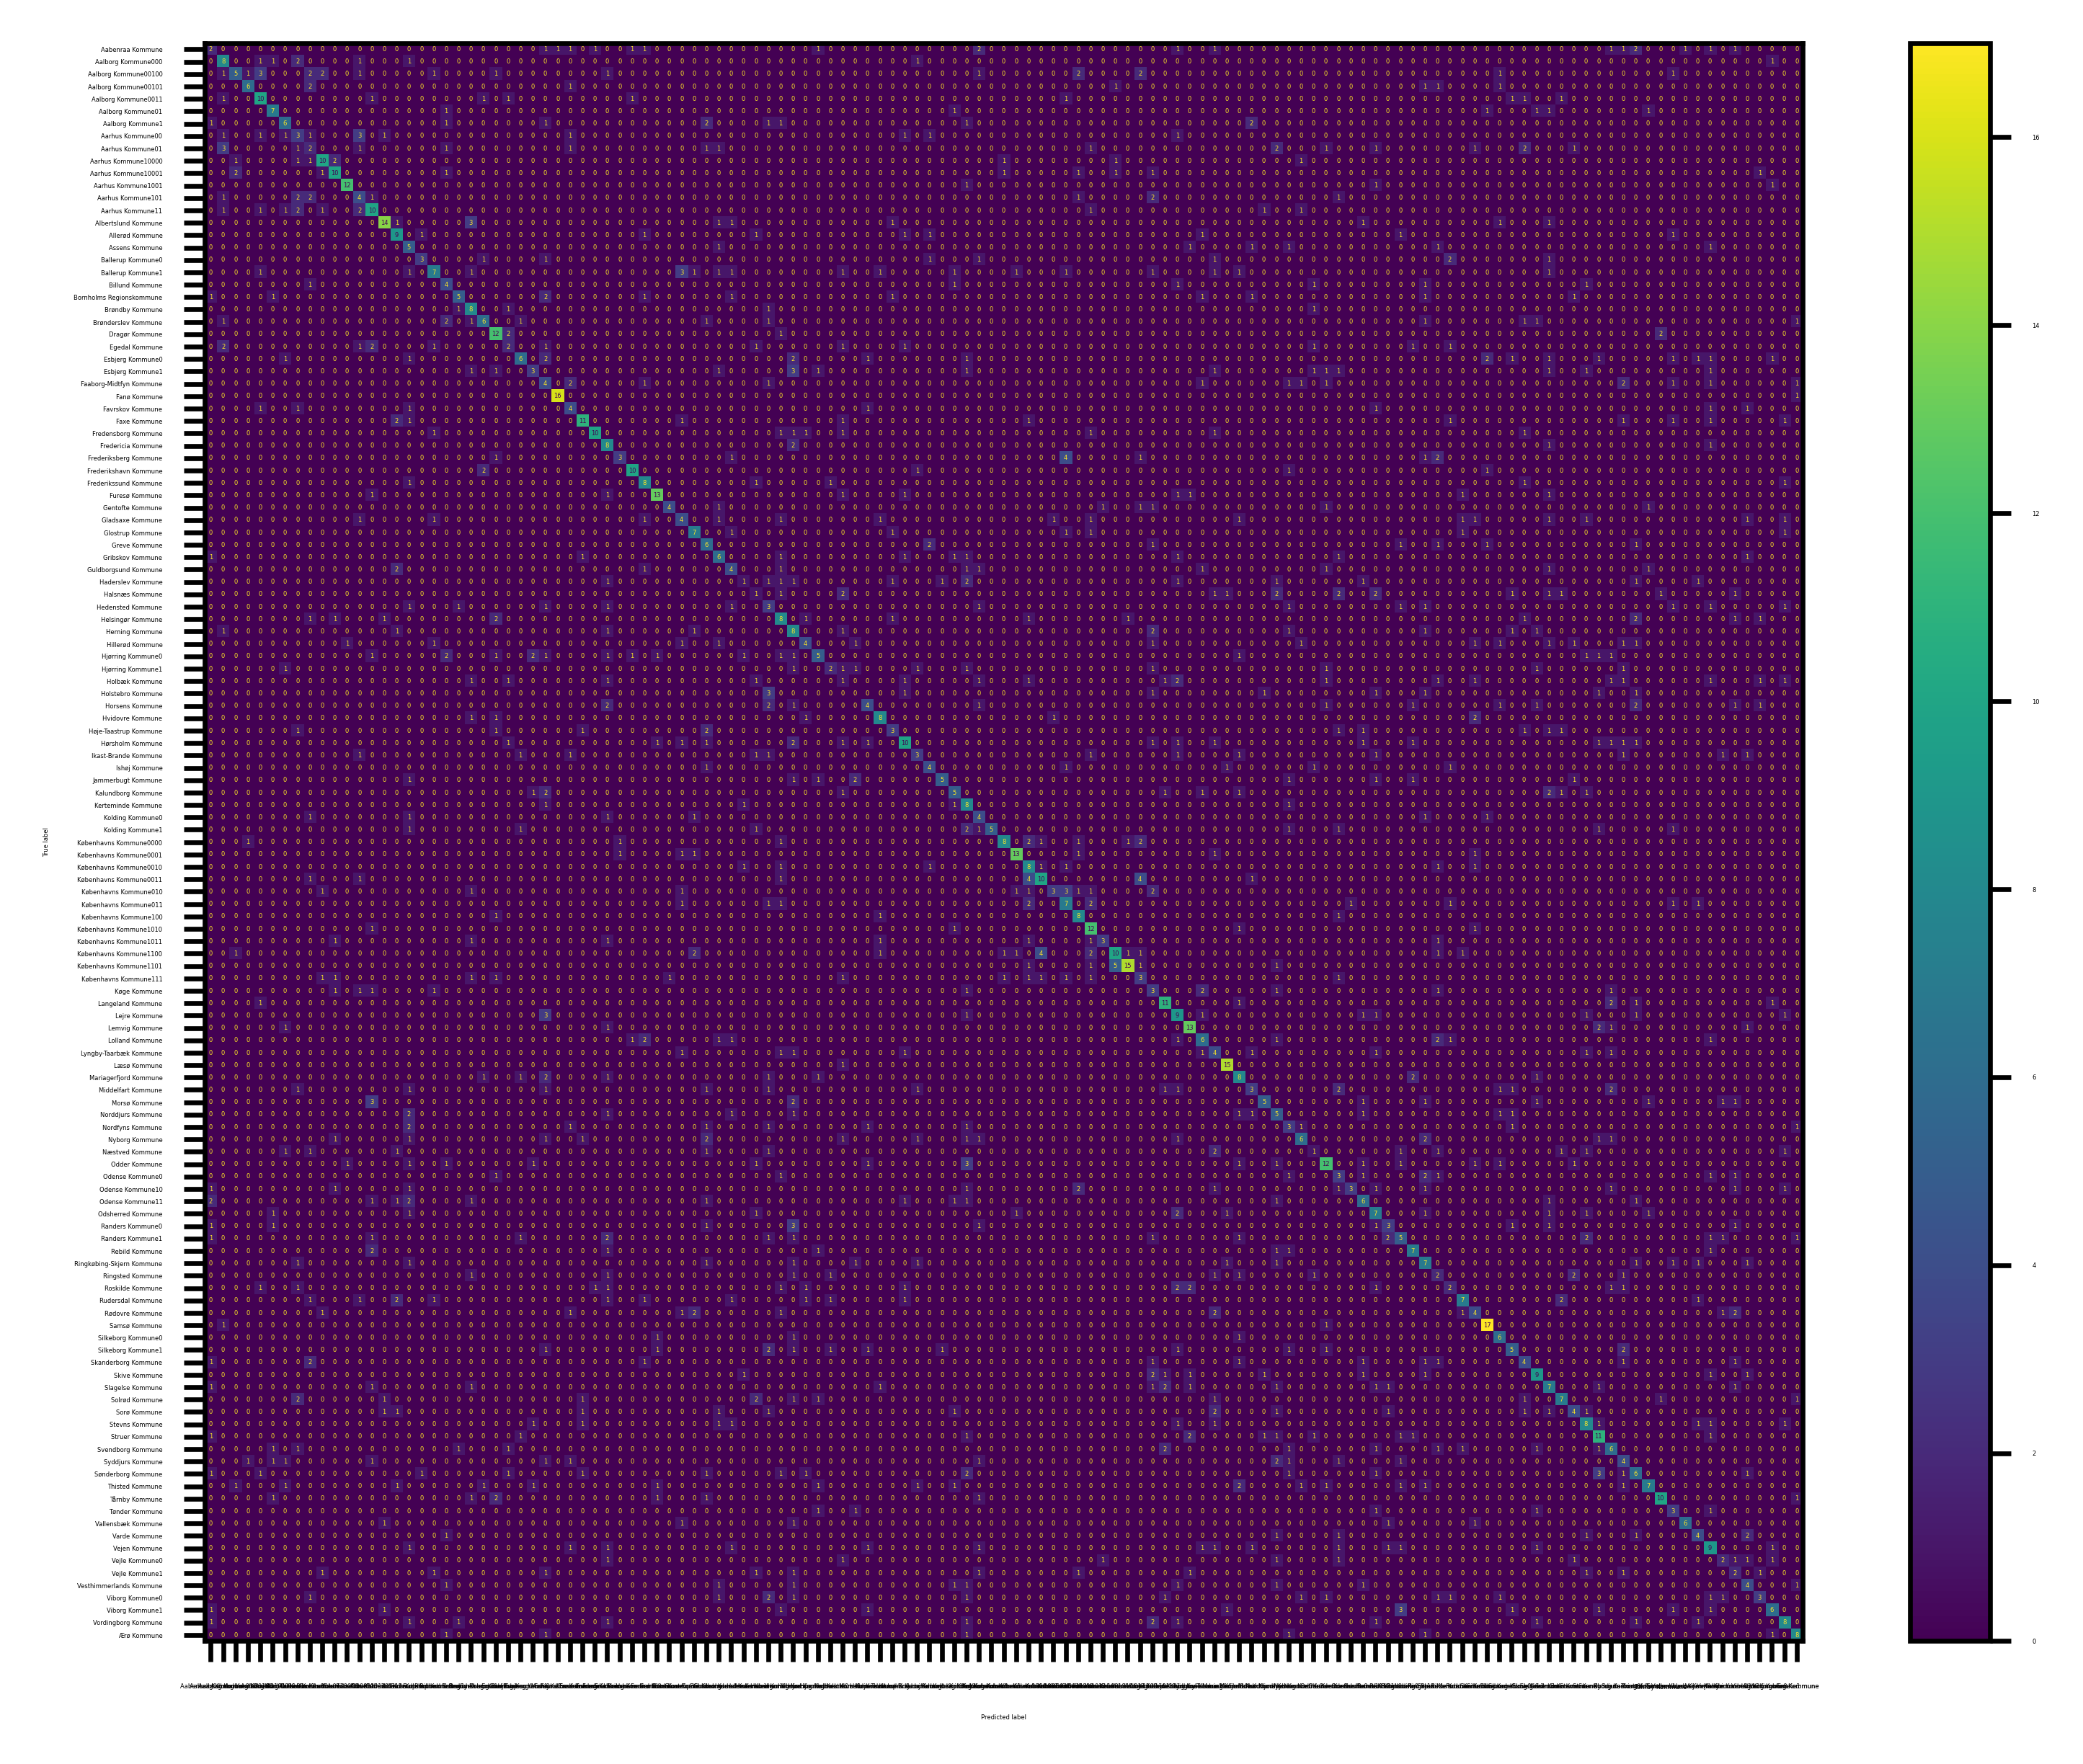

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

predictions = np.array([])
true_labels = np.array([])

for x, y in tf_test_dataset:
    y_prob = model.predict(x)
    # Apply softmax to obtain probabilities
    probabilities = tf.nn.softmax(y_prob, axis=-1).numpy()
    # Get the predicted labels (class with the highest probability)
    y_pred = tf.argmax(probabilities, axis=-1).numpy()

    predictions = np.concatenate([predictions, y_pred])
    print(y_pred)
    print(y.numpy())
    true_labels = np.concatenate([true_labels, y.numpy()])

cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
plt.rcParams['figure.dpi'] = 600
plt.rcParams['font.size'] = 1

disp.plot()
plt.show()